# FIT5202 Assignment 2A : Building Models for eCommerce Fraud Detection

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Customer Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)
 
Please add code/markdown cells if needed.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Spark SQL usage is discouraged, and you can only use pandas to format results. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 16MB, and to run locally with all CPU cores on your machine (note: if you have insufficient RAM, reducing the number of cores is acceptable.)  (2%)

In [1]:
# Import required classes
from pyspark import SparkConf
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, BooleanType, FloatType, DoubleType
from pyspark.sql.functions import col, year, month, dayofmonth, hour, minute, when, from_json, explode
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, ArrayType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

In [2]:

# Create a SparkConf object
spark_conf = SparkConf() \
    .setMaster("local[*]") \
    .setAppName("FIT5202 Assignment 2") \
    .set("spark.sql.files.maxPartitionBytes", "16000000")  

# Create a SparkSession using the SparkConf object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

# Set log level to avoid excessive logging
spark.sparkContext.setLogLevel('ERROR')

# Confirm Spark session creation
print("Spark session created successfully!")


Spark session created successfully!


1.1.2 Write code to define the schemas for the category, customer, product, browsing behaviour and transaction datasets, following the data types suggested in the metadata file. (3%)

In [3]:
curr_dir = os.getcwd()
print(curr_dir)

/home/student/BIGDATA/LABORATORY/ASSIGNMENTS/A2


In [4]:
# Schema for Customer.csv
customer_schema = StructType([
    StructField("customer_id", IntegerType(), nullable=False),  # Unique ID for each customer
    StructField("first_name", StringType(), nullable=True),
    StructField("last_name", StringType(), nullable=True),
    StructField("username", StringType(), nullable=True),
    StructField("email", StringType(), nullable=True),
    StructField("gender", StringType(), nullable=True),
    StructField("birthdate", StringType(), nullable=True),  
    StructField("first_join_date", StringType(), nullable=True)  
])

# Schema for Category.csv
category_schema = StructType([
    StructField("category_id", IntegerType(), nullable=False),  # ID for each category
    StructField("cat_level1", StringType(), nullable=True),
    StructField("cat_level2", StringType(), nullable=True),
    StructField("cat_level3", StringType(), nullable=True)
])

# Schema for Browsing_behaviour.csv
browsing_behaviour_schema = StructType([
    StructField("session_id", StringType(), nullable=False),  # ID for session
    StructField("event_type", StringType(), nullable=True),   # Type of event 
    StructField("event_time", TimestampType(), nullable=True),  # Time when event happened
    StructField("traffic_source", StringType(), nullable=True),
    StructField("device_type", StringType(), nullable=True)
])

# Schema for Product.csv
product_schema = StructType([
    StructField("id", IntegerType(), nullable=False),  # Unique product ID
    StructField("gender", StringType(), nullable=True),
    StructField("baseColour", StringType(), nullable=True),
    StructField("season", StringType(), nullable=True),
    StructField("year", IntegerType(), nullable=True),  # Release year of product
    StructField("usage", StringType(), nullable=True),
    StructField("productDisplayName", StringType(), nullable=True),
    StructField("category_id", IntegerType(), nullable=True)  # Links to category
])

# Schema for Transaction.csv
transaction_schema = StructType([
    StructField("created_at", TimestampType(), nullable=False),  # When transaction happened
    StructField("customer_id", IntegerType(), nullable=False),  # ID of customer
    StructField("transaction_id", StringType(), nullable=False),  # Unique transaction ID
    StructField("session_id", StringType(), nullable=True),
    StructField("product_metadata", StringType(), nullable=True),  
    StructField("payment_method", StringType(), nullable=True),
    StructField("payment_status", StringType(), nullable=True),
    StructField("promo_amount", FloatType(), nullable=True),
    StructField("promo_code", StringType(), nullable=True),
    StructField("shipment_fee", FloatType(), nullable=True),
    StructField("shipment_location_lat", DoubleType(), nullable=True),
    StructField("shipment_location_long", DoubleType(), nullable=True),
    StructField("total_amount", FloatType(), nullable=True),  # Total amount of the transaction
    StructField("clear_payment", BooleanType(), nullable=True)  # Whether payment was cleared
])

# Schema for Customer_session.csv
customer_session_schema = StructType([
    StructField("session_id", StringType(), nullable=False),  # Unique session ID
    StructField("customer_id", IntegerType(), nullable=False)  # Links session to customer
])

# Schema for Fraud_transaction.csv
fraud_transaction_schema = StructType([
    StructField("transaction_id", StringType(), nullable=False),  # ID for transaction
    StructField("is_fraud", BooleanType(), nullable=False)  # Whether it's a fraud transaction
])


1.1.3 Using predefined schemas, write code to load the CSV files into separate data frames. Print the schemas of all data frames. (2%)

In [5]:
print(curr_dir)

/home/student/BIGDATA/LABORATORY/ASSIGNMENTS/A2


In [6]:
# Reading in all CSV files with their respective schemas
cust_data = spark.read.csv(curr_dir + "/dataset/dataset" + "/customer.csv", header=True, schema=customer_schema)
cat_data = spark.read.csv(curr_dir + "/dataset/dataset/category.csv", header=True, schema=category_schema)
browse_data = spark.read.csv(curr_dir + "/dataset/dataset/browsing_behaviour.csv", header=True, schema=browsing_behaviour_schema)
prod_data = spark.read.csv(curr_dir + "/dataset/dataset/product.csv", header=True, schema=product_schema)
trans_data = spark.read.csv(curr_dir + "/dataset/dataset/transactions.csv", header=True, schema=transaction_schema)
session_data = spark.read.csv(curr_dir + "/dataset/dataset/customer_session.csv", header=True, schema=customer_session_schema)
fraud_data = spark.read.csv(curr_dir + "/dataset/dataset/fraud_transaction.csv", header=True, schema=fraud_transaction_schema)

# Printing the schema for each DataFrame to make sure they loaded correctly
print("Customer dataset schema:")
cust_data.printSchema()

print("\nCategory dataset schema:")
cat_data.printSchema()

print("\nBrowsing Behaviour dataset schema:")
browse_data.printSchema()

print("\nProduct dataset schema:")
prod_data.printSchema()

print("\nTransaction dataset schema:")
trans_data.printSchema()

print("\nCustomer Session dataset schema:")
session_data.printSchema()

print("\nFraud Transaction dataset schema:")
fraud_data.printSchema()


Customer dataset schema:
root
 |-- customer_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- first_join_date: string (nullable = true)


Category dataset schema:
root
 |-- category_id: integer (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)


Browsing Behaviour dataset schema:
root
 |-- session_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- device_type: string (nullable = true)


Product dataset schema:
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- baseColour: string (nullable = true)
 |-- season: string (nullable = 

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the browsing behaviour dataset, there are 10 types of events:  
VC(Viewing Category), VI(Viewing Item), VP(Viewing Promotion), AP(Add Promotion), CL(Click on a product/category) , ATC(Add a product to Shopping Cart), CO(CheckOut), HP(View HomePage), SCR(Mouse Scrolling), SER(Search for a product/category)  
We categorise them into three different levels:  
L1(actions that are highly likely lead to a purchase): AP, ATC, CO  
L2(actions may lead to purchase): VC, VP, VI, SER  
L3(not very important - just browsing):  SCR, HP, CL  
Perform the following tasks based on the loaded data frames and create a new data frame.  

1.2.1 For each transaction (linked to a browsing session), count the number of actions in each level and create 3 columns(L1_count, L2_count, L3_count).

In [7]:

# Setting up different event levels based on how likely they are to lead to a purchase
level1_events = ['AP', 'ATC', 'CO']  
level2_events = ['VC', 'VP', 'VI', 'SER']  
level3_events = ['SCR', 'HP', 'CL']  

# Adding columns to count how many events fall into each level for each session
browsing_data_levels = browse_data.withColumn(
    'level1_count', F.when(F.col('event_type').isin(level1_events), 1).otherwise(0)  # Count level 1 events
).withColumn(
    'level2_count', F.when(F.col('event_type').isin(level2_events), 1).otherwise(0)  # Count level 2 events
).withColumn(
    'level3_count', F.when(F.col('event_type').isin(level3_events), 1).otherwise(0)  # Count level 3 events
)

# Group by session_id and calculate the total count for each event level
session_level_counts = browsing_data_levels.groupBy('session_id').agg(
    F.sum('level1_count').alias('level1_count'),  # Total count for level 1 events per session
    F.sum('level2_count').alias('level2_count'),  # Total count for level 2 events per session
    F.sum('level3_count').alias('level3_count')   # Total count for level 3 events per session
)

# Join the session-level counts with the transaction data using session_id
transaction_session_counts = trans_data.join(session_level_counts, on='session_id', how='left')

# Show the results to check if the join and counts are correct
transaction_session_counts.select('transaction_id', 'session_id', 'level1_count', 'level2_count', 'level3_count').show()


+--------------------+--------------------+------------+------------+------------+
|      transaction_id|          session_id|level1_count|level2_count|level3_count|
+--------------------+--------------------+------------+------------+------------+
|f44dcf1d-214d-481...|05e595a9-9c62-433...|           2|           3|           5|
|07903c03-5469-452...|06acb999-259f-4e0...|           2|           3|          12|
|119afaf0-0b0d-44e...|06f39dc1-75d5-440...|           2|           1|           2|
|fd6ca22b-2710-4dc...|07a6ae9c-5ac5-46e...|           2|           4|           6|
|9018028b-a456-431...|07dfa7d9-3d61-4ee...|           2|           3|           2|
|bfa122dd-4825-49d...|07eebc74-3987-46f...|           2|           1|           1|
|78d34846-0588-4eb...|09824ec5-f72e-4c9...|           4|          11|          37|
|4964632a-bf22-44d...|1842d714-05a1-4bb...|           6|           1|           5|
|6ee66f26-a840-44b...|18cd0f24-9e53-4e0...|           7|           8|           1|
|1ef

1.2.2 Create two columns with a percentage ratio of L1 and L2 actions. (i.e. L1 ratio = L1/(L1+L2+L3) * 100%)

In [8]:
# We already have the counts for level 1 (L1), level 2 (L2), and level 3 (L3) actions
# Now, let's calculate the percentage ratios for L1 and L2 actions

# Adding new columns to calculate the percentage of L1 and L2 actions
transaction_session_counts = transaction_session_counts.withColumn(
    'L1_ratio', 
    (F.col('level1_count') / (F.col('level1_count') + F.col('level2_count') + F.col('level3_count')) * 100)  # Percentage of L1 events
).withColumn(
    'L2_ratio', 
    (F.col('level2_count') / (F.col('level1_count') + F.col('level2_count') + F.col('level3_count')) * 100)  # Percentage of L2 events
)

# Show transaction_id, session_id, the event counts, and the new ratio columns
transaction_session_counts.select(
    'transaction_id', 'session_id', 'level1_count', 'level2_count', 'level3_count', 'L1_ratio', 'L2_ratio'
).show()


+--------------------+--------------------+------------+------------+------------+------------------+------------------+
|      transaction_id|          session_id|level1_count|level2_count|level3_count|          L1_ratio|          L2_ratio|
+--------------------+--------------------+------------+------------+------------+------------------+------------------+
|f44dcf1d-214d-481...|05e595a9-9c62-433...|           2|           3|           5|              20.0|              30.0|
|07903c03-5469-452...|06acb999-259f-4e0...|           2|           3|          12| 11.76470588235294|17.647058823529413|
|119afaf0-0b0d-44e...|06f39dc1-75d5-440...|           2|           1|           2|              40.0|              20.0|
|fd6ca22b-2710-4dc...|07a6ae9c-5ac5-46e...|           2|           4|           6|16.666666666666664| 33.33333333333333|
|9018028b-a456-431...|07dfa7d9-3d61-4ee...|           2|           3|           2| 28.57142857142857|42.857142857142854|
|bfa122dd-4825-49d...|07eebc74-3

1.2.3 For each unique browsing session, based on event_time, extract the time of day as 4 groups: morning(6am-11:59am), afternoon(12pm-5:59pm), evening(6pm-11:59pm), night(12am-5:59am), add a column. (note: use medium time if a browsing session spans across different groups. For example, if a session starts at 10 am and ends at 1 pm, use 11:30 => (10+13)/2).

In [9]:
# Just checking out the first few rows of the browsing data to see what it looks like
print("Showing the first 5 rows of Browsing Behavior Data:")
browse_data.show(5, truncate=False)


Showing the first 5 rows of Browsing Behavior Data:
+------------------------------------+----------+-----------------------+--------------+-----------+
|session_id                          |event_type|event_time             |traffic_source|device_type|
+------------------------------------+----------+-----------------------+--------------+-----------+
|c9718135-8134-42b2-8e1e-2737fd6b49b1|AP        |2020-12-17 07:04:52.331|MOBILE        |Android    |
|c9718135-8134-42b2-8e1e-2737fd6b49b1|CL        |2020-12-06 09:07:47.331|MOBILE        |Android    |
|c9718135-8134-42b2-8e1e-2737fd6b49b1|SER       |2020-12-17 07:12:08.331|MOBILE        |Android    |
|c9718135-8134-42b2-8e1e-2737fd6b49b1|CL        |2021-01-08 02:28:32.331|MOBILE        |Android    |
|c9718135-8134-42b2-8e1e-2737fd6b49b1|ATC       |2021-01-19 00:17:38.331|MOBILE        |Android    |
+------------------------------------+----------+-----------------------+--------------+-----------+
only showing top 5 rows



In [10]:

# Convert event_time from UTC to AEDT (Australian Eastern Daylight Time) for local analysis
browse_data_aedt = browse_data.withColumn('event_time_aedt', 
    F.from_utc_timestamp(F.col('event_time'), 'Australia/Melbourne'))

# Extract the hour from the AEDT event_time
browse_data_time = browse_data_aedt.withColumn('event_hour', F.hour(F.col('event_time_aedt')))

# Calculate the median hour of activity for each session
browse_data_median_time = browse_data_time.groupBy('session_id').agg(
    F.expr('percentile_approx(event_hour, 0.5)').alias('median_hour')  
)

# Define a function to assign time of day based on the hour
def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

# Create a UDF to apply the time of day function
time_of_day_udf = F.udf(assign_time_of_day)

# Apply the time of day categorization based on the median hour
browse_data_with_time_of_day = browse_data_median_time.withColumn(
    'time_of_day', time_of_day_udf(F.col('median_hour').cast(IntegerType()))
)

# Join the time_of_day data with transaction data using session_id
transaction_with_time_of_day = trans_data.join(browse_data_with_time_of_day, on='session_id', how='left')



1.2.4 Join data frames to find customer information and add columns to feature_df: gender, age, geolocation, first join year. (note: For some columns, you need to perform transformations. For age, keep the integer only by rounding.)

In [11]:
# Join the customer data with the transaction data using customer_id to get customer details
customer_feat = transaction_with_time_of_day.join(cust_data, on='customer_id', how='left')

# Import necessary functions for date operations
from pyspark.sql.functions import year, round, current_date

# Calculate the age based on the 'birthdate' column and current date
customer_feat = customer_feat.withColumn('age', 
    round((year(current_date()) - year(F.col('birthdate')))).cast(IntegerType())  # Calculate age from birthdate
)

# Add the 'gender' and 'first_join_year' columns from the customer data
customer_feat = customer_feat.withColumn('gender', F.col('gender')) \
    .withColumn('first_join_year', year(F.col('first_join_date')))  # Get the year the customer first joined

# Show the result to check if age, gender, and first join year are added correctly
customer_feat.select('transaction_id', 'session_id', 'age', 'gender', 'first_join_year').show()


+--------------------+--------------------+---+------+---------------+
|      transaction_id|          session_id|age|gender|first_join_year|
+--------------------+--------------------+---+------+---------------+
|511f59f8-3ef5-438...|4d55839d-4b3e-406...| 31|     F|           2019|
|8e509f58-7f8d-421...|4d5839f4-313f-45c...| 32|     F|           2020|
|29d32f23-a07a-4f2...|4d5ad667-a524-4de...| 28|     F|           2020|
|a3e90650-4db3-408...|4d5e5a02-dfed-40e...| 24|     F|           2017|
|12ffdc68-a0ba-44e...|000128d0-c51c-411...| 24|     F|           2018|
|430dc90b-6c04-408...|b8e4ba8c-2810-4c2...| 26|     F|           2018|
|89a39293-dee2-48a...|756a8aed-7ef5-4a1...| 26|     F|           2018|
|cddea303-22d6-41f...|4d6363c2-7275-4ec...| 22|     F|           2017|
|9cf8b365-0b86-4c3...|4d6e460e-ba93-4c8...| 46|     F|           2017|
|6323379e-5dee-4d0...|4d9fd70f-14a8-4c3...| 35|     F|           2018|
|4a761b1e-4109-4c3...|4da483d3-23b0-40f...| 17|     F|           2018|
|d5c5d

1.2.5 Join data frames to find out the number of purchases the customer has made, add a column.

In [12]:
# Group transaction data by customer_id to count the number of purchases each customer has made
customer_purchase_count = transaction_with_time_of_day.groupBy('customer_id').agg(
    F.count('transaction_id').alias('purchase_count')  # Count the transactions per customer
)

# Join the purchase count with the customer feature DataFrame
final_feature_df = customer_feat.join(customer_purchase_count, on='customer_id', how='left')

# Show the final DataFrame to check if the purchase count was added correctly
final_feature_df.select('customer_id', 'transaction_id', 'age', 'gender', 'first_join_year', 'purchase_count').show()


+-----------+--------------------+---+------+---------------+--------------+
|customer_id|      transaction_id|age|gender|first_join_year|purchase_count|
+-----------+--------------------+---+------+---------------+--------------+
|      90136|a3e90650-4db3-408...| 24|     F|           2017|            24|
|       6664|b5a01723-75a9-44e...| 25|     F|           2019|            47|
|      32840|4a761b1e-4109-4c3...| 17|     F|           2018|            67|
|      60646|430dc90b-6c04-408...| 26|     F|           2018|            55|
|      17336|96c23186-c8d5-4f4...| 37|     F|           2018|            32|
|      79403|3e2d5989-240d-458...| 32|     F|           2017|           148|
|      18960|12ffdc68-a0ba-44e...| 24|     F|           2018|            22|
|      22576|8e509f58-7f8d-421...| 32|     F|           2020|            17|
|      18696|29d32f23-a07a-4f2...| 28|     F|           2020|            49|
|      60389|542d5d81-3d4b-4c6...| 17|     F|           2019|            38|

1.2.6 Attach the transaction labels for fraud/non-fraud.

In [13]:
# Join the fraud data with the final feature DataFrame using transaction_id
# 'is_fraud' column contains 1 for fraud and 0 for non-fraud
final_feature_with_fraud = final_feature_df.join(fraud_data, on='transaction_id', how='left')

# Fill missing values in the 'is_fraud' column with 0, assuming missing means non-fraud
final_feature_with_fraud = final_feature_with_fraud.fillna({'is_fraud': 0})

# Show the final DataFrame to check if fraud labels are correctly attached
final_feature_with_fraud.select('transaction_id', 'customer_id', 'is_fraud', 'purchase_count', 'age', 'gender').show()


+--------------------+-----------+--------+--------------+---+------+
|      transaction_id|customer_id|is_fraud|purchase_count|age|gender|
+--------------------+-----------+--------+--------------+---+------+
|511f59f8-3ef5-438...|      14159|   false|           102| 31|     F|
|8e509f58-7f8d-421...|      22576|   false|            17| 32|     F|
|29d32f23-a07a-4f2...|      18696|   false|            49| 28|     F|
|a3e90650-4db3-408...|      90136|   false|            24| 24|     F|
|12ffdc68-a0ba-44e...|      18960|   false|            22| 24|     F|
|430dc90b-6c04-408...|      60646|   false|            55| 26|     F|
|89a39293-dee2-48a...|       5901|   false|            23| 26|     F|
|cddea303-22d6-41f...|      69072|   false|           314| 22|     F|
|9cf8b365-0b86-4c3...|      92076|   false|            68| 46|     F|
|6323379e-5dee-4d0...|      51799|   false|            70| 35|     F|
|4a761b1e-4109-4c3...|      32840|   false|            67| 17|     F|
|d5c5d485-9d93-4d2..

In [13]:
final_feature_with_fraud.show(n=5, truncate=False)


+------------------------------------+-----------+------------------------------------+-----------------------+------------------------------------------------------------------------------------------------------------------------+--------------+--------------+------------+----------+------------+---------------------+----------------------+------------+-------------+-----------+-----------+----------+---------+------------------------------------+-------------------------------------------------------+------+----------+---------------+---+---------------+--------------+--------+
|transaction_id                      |customer_id|session_id                          |created_at             |product_metadata                                                                                                        |payment_method|payment_status|promo_amount|promo_code|shipment_fee|shipment_location_lat|shipment_location_long|total_amount|clear_payment|median_hour|time_of_day|first_name|last_n

In [14]:
final_feature_with_fraud.toPandas().head(5)


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,transaction_id,customer_id,session_id,created_at,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,...,last_name,username,email,gender,birthdate,first_join_date,age,first_join_year,purchase_count,is_fraud
0,f239a6dc-5fce-406d-b49d-cea5d8e393db,28,162c74c1-34b8-4be7-b466-e2b161b1dddf,2023-09-03 19:02:19.822,"[{'product_id': 14699, 'quantity': 1, 'item_pr...",Credit Card,Success,0.0,None,25000.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False
1,3d800432-2c97-4797-9139-77707fb7de98,28,19dd6cbf-739f-4df4-a7fe-b79e872474ba,2023-08-12 18:39:33.822,"[{'product_id': 37316, 'quantity': 2, 'item_pr...",OVO,Fail,0.0,None,10000.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False
2,bcdb2e92-30ca-4b1f-a190-8d8ac3dab17f,28,b53e71c3-2803-4a30-912d-bc181a77176a,2023-06-29 17:43:44.822,"[{'product_id': 32492, 'quantity': 1, 'item_pr...",OVO,Fail,0.0,None,0.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False
3,e2e32171-5a6c-49f1-8be2-5808e927335c,28,e895d9d9-71d1-47ab-8fcb-ef25ee94fbbd,2023-11-08 19:51:03.822,"[{'product_id': 19643, 'quantity': 1, 'item_pr...",Credit Card,Success,4756.0,AZ2022,50000.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False
4,9b505e24-ac61-4ba5-92be-4fb59b642fa2,28,50a5e715-6248-4596-9cfa-ca217df03577,2023-04-24 15:49:39.822,"[{'product_id': 21507, 'quantity': 1, 'item_pr...",Credit Card,Success,0.0,None,10000.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False


### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
**1.3.1 With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b) For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count. (3%)**

In [14]:
# Calculate purchase_count by counting transactions for each customer
purchase_count_df = final_feature_with_fraud.groupBy('customer_id').agg(F.count('transaction_id').alias('purchase_count'))

# Join the purchase_count back to the original feature DataFrame
customer_feat = final_feature_with_fraud.join(purchase_count_df, on='customer_id', how='left')

# Get basic statistics for numeric columns, including purchase_count
numeric_cols = ['promo_amount', 'shipment_fee', 'total_amount', 'age', 'purchase_count']
summary_stats = final_feature_with_fraud.select(numeric_cols).describe()
summary_stats.show()

# Calculate percentiles (25th, 50th, 75th) for numeric columns
percentiles = final_feature_with_fraud.approxQuantile(numeric_cols, [0.25, 0.5, 0.75], 0.01)
percentile_df = spark.createDataFrame(percentiles, schema=["25th", "50th", "75th"]).toPandas()

# Show top 5 most frequent values for non-numeric columns
non_numeric_cols = ['payment_method', 'payment_status', 'gender', 'time_of_day']
for col in non_numeric_cols:
    print(f"\nTop 5 values for {col}:")
    final_feature_with_fraud.groupBy(col).count().orderBy(F.desc('count')).show(5, truncate=False)

# Show value counts for boolean columns like 'is_fraud'
boolean_cols = ['is_fraud']
for col in boolean_cols:
    print(f"\nValue counts for {col}:")
    final_feature_with_fraud.groupBy(col).count().show(truncate=False)


+-------+------------------+-----------------+-----------------+-----------------+------------------+
|summary|      promo_amount|     shipment_fee|     total_amount|              age|    purchase_count|
+-------+------------------+-----------------+-----------------+-----------------+------------------+
|  count|            657989|           657989|           657989|           657989|            657989|
|   mean|2141.9979923676538|9189.986458740192|550212.4390711699| 28.3703815717284|63.824585213430616|
| stddev|3101.9509587933367|9377.998758096042|817215.9515857601|7.288467165050656| 67.53910564642443|
|    min|               0.0|              0.0|          10898.0|                8|                 1|
|    max|           24326.0|          50000.0|      2.3504488E7|               70|               497|
+-------+------------------+-----------------+-----------------+-----------------+------------------+


Top 5 values for payment_method:
+--------------+------+
|payment_method|count |

**1.3.2 Explore the dataframe and write code to present two plots worthy of presentation to the company, describe your plots and discuss the findings from the plots. (8%)**
One of the plots needs to be based on feature_df in regard to fraudulent behaviour; you’re free to choose the other one.  
Hint 1: You can use basic plots (e.g., histograms, line charts, scatter plots) to show the relationship between a column and the label or more advanced plots like correlation plots.  
Hint 2: If your data is too large for plotting, consider using sampling before plotting.  
150 words max for each plot’s description and discussion  
Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  



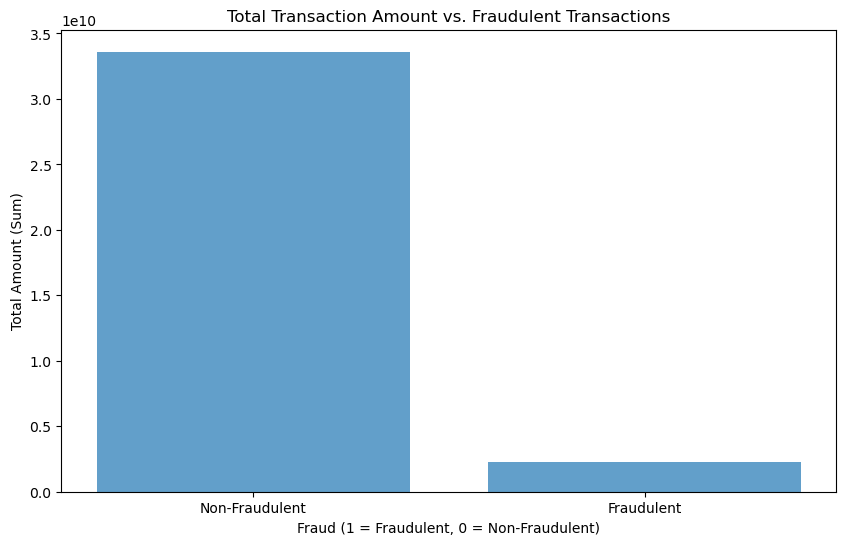

In [15]:
fraud_col = 'is_fraud'
# Sample 10% of the data for visualization
sampled_df = final_feature_with_fraud.sample(fraction=0.1, seed=42)

# Group by fraud label and sum the total transaction amounts
summary_df = sampled_df.groupBy(fraud_col).agg(F.sum('total_amount').alias('total_amount_sum')).toPandas()

# Create a bar plot of total transaction amount vs. fraud label
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(summary_df[fraud_col], summary_df['total_amount_sum'], alpha=0.7)
plt.xlabel('Fraud (1 = Fraudulent, 0 = Non-Fraudulent)')
plt.ylabel('Total Amount (Sum)')
plt.title('Total Transaction Amount vs. Fraudulent Transactions')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.show()


## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
300 words max for the discussion
Please only use the provided data for model building
You can create/add additional features based on the dataset
Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns

In [16]:

# Extract the stages from the saved pipeline model
vector_assembler = None
for stage in saved_model.stages:
    if isinstance(stage, VectorAssembler):
        vector_assembler = stage
        break

# Retrieve the list of features used during training
if vector_assembler:
    training_feature_columns = vector_assembler.getInputCols()
    print("Features used in Model Training:")
    print(training_feature_columns)
else:
    print("VectorAssembler not found in the pipeline model.")


NameError: name 'saved_model' is not defined

In [17]:
final_feature_with_fraud.toPandas().head(5)


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,transaction_id,customer_id,session_id,created_at,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,...,last_name,username,email,gender,birthdate,first_join_date,age,first_join_year,purchase_count,is_fraud
0,f239a6dc-5fce-406d-b49d-cea5d8e393db,28,162c74c1-34b8-4be7-b466-e2b161b1dddf,2023-09-03 19:02:19.822,"[{'product_id': 14699, 'quantity': 1, 'item_pr...",Credit Card,Success,0.0,None,25000.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False
1,3d800432-2c97-4797-9139-77707fb7de98,28,19dd6cbf-739f-4df4-a7fe-b79e872474ba,2023-08-12 18:39:33.822,"[{'product_id': 37316, 'quantity': 2, 'item_pr...",OVO,Fail,0.0,None,10000.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False
2,bcdb2e92-30ca-4b1f-a190-8d8ac3dab17f,28,b53e71c3-2803-4a30-912d-bc181a77176a,2023-06-29 17:43:44.822,"[{'product_id': 32492, 'quantity': 1, 'item_pr...",OVO,Fail,0.0,None,0.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False
3,e2e32171-5a6c-49f1-8be2-5808e927335c,28,e895d9d9-71d1-47ab-8fcb-ef25ee94fbbd,2023-11-08 19:51:03.822,"[{'product_id': 19643, 'quantity': 1, 'item_pr...",Credit Card,Success,4756.0,AZ2022,50000.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False
4,9b505e24-ac61-4ba5-92be-4fb59b642fa2,28,50a5e715-6248-4596-9cfa-ca217df03577,2023-04-24 15:49:39.822,"[{'product_id': 21507, 'quantity': 1, 'item_pr...",Credit Card,Success,0.0,None,10000.0,...,Sudiati,99458eff-964c-4a3f-8ef8-25d9267112d8,99458eff_964c_4a3f_8ef8_25d9267112d8@zakyfound...,F,2003-01-03,2020-08-01,21,2020,24,False


In [18]:
column_names = final_feature_with_fraud.columns

print("Column Names: ")
for col in column_names:
    print(col)


Column Names: 
transaction_id
customer_id
session_id
created_at
product_metadata
payment_method
payment_status
promo_amount
promo_code
shipment_fee
shipment_location_lat
shipment_location_long
total_amount
clear_payment
median_hour
time_of_day
first_name
last_name
username
email
gender
birthdate
first_join_date
age
first_join_year
purchase_count
is_fraud


2.1.2 Write code to create/transform the columns based on your discussion above
Hint: You can use one data frame for both use cases (classification and k-mean later in part 3) since you can select your desired columns as the input and output for each use case. 

In [ ]:
# Drop unnecessary columns like transaction, customer, and session info
columns_to_drop = ['transaction_id', 'customer_id', 'session_id', 'first_name', 'last_name', 'username', 'email']  
df_cleaned = final_feature_with_fraud.drop(*columns_to_drop)

# Cast 'is_fraud' column to integer for consistency
df_cleaned = df_cleaned.withColumn('is_fraud', col('is_fraud').cast('int'))

# Create new columns for date and time components, and check if a promo code was used
transformed_df = df_cleaned.withColumn('created_year', year(col('created_at'))) \
                           .withColumn('created_month', month(col('created_at'))) \
                           .withColumn('created_day', dayofmonth(col('created_at'))) \
                           .withColumn('created_hour', hour(col('created_at'))) \
                           .withColumn('created_minute', minute(col('created_at'))) \
                           .withColumn('promo_code_used', when(col('promo_code').isNotNull(), 1).otherwise(0)) \
                           .withColumn('birth_year', year(col('birthdate'))) \
                           .withColumn('birth_month', month(col('birthdate'))) \
                           .withColumn('birth_day', dayofmonth(col('birthdate'))) \
                           .withColumn('join_year', year(col('first_join_date'))) \
                           .withColumn('join_month', month(col('first_join_date'))) \
                           .withColumn('join_day', dayofmonth(col('first_join_date')))

# Parse 'product_metadata' column into an array of structs and explode the array into individual rows
product_schema = ArrayType(StructType([
    StructField("product_id", IntegerType(), True),
    StructField("quantity", IntegerType(), True),
    StructField("item_price", FloatType(), True)
]))

transformed_df_cleaned = transformed_df.withColumn("product_array", from_json(col("product_metadata"), product_schema))

# Explode the product array into individual rows
transformed_df_cleaned = transformed_df_cleaned.withColumn("product", explode("product_array"))

# Extract individual fields like product_id, quantity, and item_price from the exploded product data
transformed_df_cleaned = transformed_df_cleaned.withColumn("product_id", col("product.product_id")) \
                                               .withColumn("quantity", col("product.quantity")) \
                                               .withColumn("item_price", col("product.item_price"))

# Drop unnecessary columns that are no longer needed
transformed_df_cleaned = transformed_df_cleaned.drop("product", "product_metadata", "product_array", "created_at")


### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

In [ ]:
from pyspark.sql.functions import col, when, year, month, dayofmonth, hour, minute
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, ArrayType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col


In [ ]:

# Index and encode categorical columns (payment_status, payment_method, time_of_day)
indexer_payment_status = StringIndexer(inputCol="payment_status", outputCol="payment_status_index")
indexer_payment_method = StringIndexer(inputCol="payment_method", outputCol="payment_method_index")
encoder_payment_status = OneHotEncoder(inputCol="payment_status_index", outputCol="payment_status_encoded")
encoder_payment_method = OneHotEncoder(inputCol="payment_method_index", outputCol="payment_method_encoded")

# One-hot encode time_of_day column
indexer_time_of_day = StringIndexer(inputCol="time_of_day", outputCol="new_time_of_day_index")
encoder_time_of_day = OneHotEncoder(inputCol="new_time_of_day_index", outputCol="new_time_of_day_encoded")

# Dynamically create a list of feature columns (excluding 'is_fraud')
feature_columns = [field.name for field in transformed_df_cleaned.schema.fields 
                   if isinstance(field.dataType, (IntegerType, FloatType)) and field.name != 'is_fraud']

# Assemble all feature columns into a single vector for machine learning
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Define classifiers (RandomForest and GBT) to predict fraud
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="is_fraud", predictionCol="rf_prediction")
gbt_classifier = GBTClassifier(featuresCol="features", labelCol="is_fraud", predictionCol="gbt_prediction")


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 35922)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 271, in accum_updates
   

**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

In [21]:
# Create pipelines for both RandomForest and GBT classifiers
pipeline_rf = Pipeline(stages=[indexer_payment_status, indexer_payment_method, encoder_payment_status,
                               encoder_payment_method, indexer_time_of_day, encoder_time_of_day, 
                               assembler, rf_classifier])

pipeline_gbt = Pipeline(stages=[indexer_payment_status, indexer_payment_method, encoder_payment_status,
                                encoder_payment_method, indexer_time_of_day, encoder_time_of_day, 
                                assembler, gbt_classifier])


### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing purposes.
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset) and do a train/test split or use one year of data for training and another year for testing. 

In [22]:
train_data, test_data = transformed_df_cleaned.randomSplit([0.8, 0.2], seed=33)

In [23]:
train_data.show()

+--------------+--------------+------------+----------+------------+---------------------+----------------------+------------+-------------+-----------+-----------+------+----------+---------------+---+---------------+--------------+--------+------------+-------------+-----------+------------+--------------+---------------+----------+-----------+---------+---------+----------+--------+----------+--------+----------+
|payment_method|payment_status|promo_amount|promo_code|shipment_fee|shipment_location_lat|shipment_location_long|total_amount|clear_payment|median_hour|time_of_day|gender| birthdate|first_join_date|age|first_join_year|purchase_count|is_fraud|created_year|created_month|created_day|created_hour|created_minute|promo_code_used|birth_year|birth_month|birth_day|join_year|join_month|join_day|product_id|quantity|item_price|
+--------------+--------------+------------+----------+------------+---------------------+----------------------+------------+-------------+-----------+--------

### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [24]:
# Fit the pipeline on the training data
pipeline_fitted_rf = pipeline_rf.fit(train_data)
pipeline_fitted_gbt = pipeline_gbt.fit(train_data)

# Use the trained models to predict on the test data
rf_predictions = pipeline_fitted_rf.transform(test_data)
gbt_predictions = pipeline_fitted_gbt.transform(test_data)

# Show prediction results
rf_predictions.select('features', 'rf_prediction', 'probability').show(truncate=False)
gbt_predictions.select('features', 'gbt_prediction', 'probability').show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------+-------------+-----------------------------------------+
|features                                                                                                                 |rf_prediction|probability                              |
+-------------------------------------------------------------------------------------------------------------------------+-------------+-----------------------------------------+
|[0.0,0.0,276327.0,7.0,17.0,2020.0,2023.0,12.0,7.0,21.0,51.0,0.0,2007.0,4.0,30.0,2020.0,6.0,7.0,51507.0,1.0,276327.0]     |0.0          |[0.94772274126649,0.05227725873350988]   |
|[0.0,0.0,475275.0,8.0,23.0,2016.0,2022.0,5.0,17.0,22.0,30.0,0.0,2001.0,3.0,3.0,2016.0,11.0,6.0,9204.0,1.0,475275.0]      |0.0          |[0.9462012715929198,0.05379872840708009] |
|[0.0,0.0,391942.0,19.0,32.0,2019.0,2021.0,2.0,10.0,9.0,15.0,0.0,1992.0,10.0,30.0,2019.0,2.0,10.0,37

In [25]:
# Split the data into training and test sets
train_data, test_data = transformed_df_cleaned.randomSplit([0.8, 0.2], seed=42)

# Predict on both training and test data for Random Forest and GBT models
rf_train_predictions = pipeline_fitted_rf.transform(train_data)
rf_test_predictions = pipeline_fitted_rf.transform(test_data)
gbt_train_predictions = pipeline_fitted_gbt.transform(train_data)
gbt_test_predictions = pipeline_fitted_gbt.transform(test_data)

# Set up evaluators to calculate accuracy
evaluator_rf = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="rf_prediction", metricName="accuracy")
evaluator_gbt = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="gbt_prediction", metricName="accuracy")

# Calculate accuracy for Random Forest
rf_train_accuracy = evaluator_rf.evaluate(rf_train_predictions)
rf_test_accuracy = evaluator_rf.evaluate(rf_test_predictions)

# Calculate accuracy for Gradient-Boosted Trees
gbt_train_accuracy = evaluator_gbt.evaluate(gbt_train_predictions)
gbt_test_accuracy = evaluator_gbt.evaluate(gbt_test_predictions)

# Print out the training and test accuracy for both models
print(f"Random Forest Training Accuracy: {rf_train_accuracy}")
print(f"Random Forest Testing Accuracy: {rf_test_accuracy}")

print(f"Gradient-Boosted Tree Training Accuracy: {gbt_train_accuracy}")
print(f"Gradient-Boosted Tree Testing Accuracy: {gbt_test_accuracy}")


Random Forest Training Accuracy: 0.9399537242439563
Random Forest Testing Accuracy: 0.9396347702070049
Gradient-Boosted Tree Training Accuracy: 0.9411854228788988
Gradient-Boosted Tree Testing Accuracy: 0.9407147507776894


2.4.2 For both models (RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using PySpark MLlib/ML APIs.
Draw a ROC plot.
Discuss which one is the better model (no word limit; please keep it concise)

In [26]:

 #Helper function to calculate confusion matrix components (TP, TN, FP, FN)
def get_confusion_matrix_counts(predictions, label_col, prediction_col):
    tp = predictions.filter((col(label_col) == 1) & (col(prediction_col) == 1)).count()
    tn = predictions.filter((col(label_col) == 0) & (col(prediction_col) == 0)).count()
    fp = predictions.filter((col(label_col) == 0) & (col(prediction_col) == 1)).count()
    fn = predictions.filter((col(label_col) == 1) & (col(prediction_col) == 0)).count()
    return tp, tn, fp, fn

# Calculate TP, TN, FP, FN for Random Forest and GBT models
rf_tp, rf_tn, rf_fp, rf_fn = get_confusion_matrix_counts(rf_train_predictions, "is_fraud", "rf_prediction")
gbt_tp, gbt_tn, gbt_fp, gbt_fn = get_confusion_matrix_counts(gbt_train_predictions, "is_fraud", "gbt_prediction")

# Print confusion matrix results for both models
print(f"Random Forest: TP={rf_tp}, TN={rf_tn}, FP={rf_fp}, FN={rf_fn}")
print(f"Gradient-Boosted Tree: TP={gbt_tp}, TN={gbt_tn}, FP={gbt_fp}, FN={gbt_fn}")

# Define evaluators for AUC, Precision, and Recall
evaluator_auc = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rf_prediction", metricName="areaUnderROC")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="rf_prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="rf_prediction", metricName="weightedRecall")

# Compute metrics for Random Forest
rf_auc = evaluator_auc.evaluate(rf_test_predictions)
rf_precision = evaluator_precision.evaluate(rf_test_predictions)
rf_recall = evaluator_recall.evaluate(rf_test_predictions)
rf_accuracy = (rf_tp + rf_tn) / (rf_tp + rf_tn + rf_fp + rf_fn)

# Compute metrics for Gradient-Boosted Tree
evaluator_auc.setRawPredictionCol("gbt_prediction")
gbt_auc = evaluator_auc.evaluate(gbt_test_predictions)
evaluator_precision.setPredictionCol("gbt_prediction")
gbt_precision = evaluator_precision.evaluate(gbt_test_predictions)
evaluator_recall.setPredictionCol("gbt_prediction")
gbt_recall = evaluator_recall.evaluate(gbt_test_predictions)
gbt_accuracy = (gbt_tp + gbt_tn) / (gbt_tp + gbt_tn + gbt_fp + gbt_fn)

# Print evaluation metrics for both models
print(f"Random Forest: AUC={rf_auc}, Accuracy={rf_accuracy}, Precision={rf_precision}, Recall={rf_recall}")
print(f"Gradient-Boosted Tree: AUC={gbt_auc}, Accuracy={gbt_accuracy}, Precision={gbt_precision}, Recall={gbt_recall}")


Random Forest: TP=0, TN=728795, FP=0, FN=46557
Gradient-Boosted Tree: TP=3508, TN=726242, FP=2553, FN=43049
Random Forest: AUC=0.5, Accuracy=0.9399537242439563, Precision=0.8829135013819709, Recall=0.9396347702070049
Gradient-Boosted Tree: AUC=0.5350187304265484, Accuracy=0.9411854228788988, Precision=0.9210331258397912, Recall=0.9407147507776894


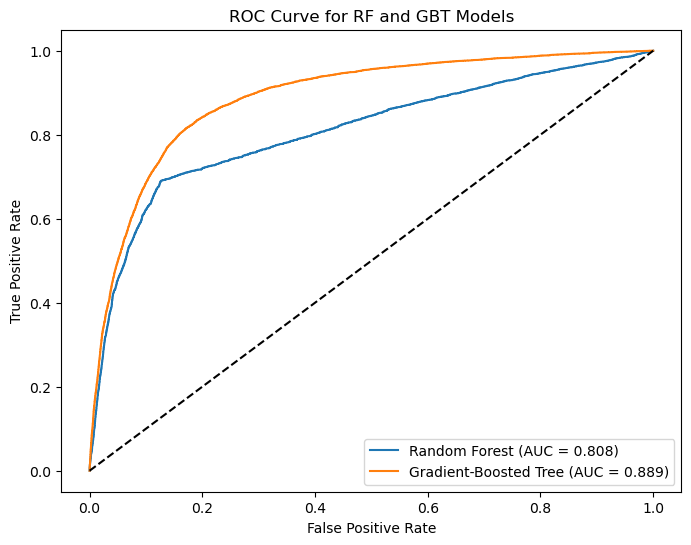

In [27]:
# Function to manually plot the ROC curve
def plot_roc_curve(predictions, model_name, prediction_col):
    evaluator_auc = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol=prediction_col, metricName="areaUnderROC")
    
    # Extract raw predictions and labels
    prediction_and_labels = predictions.select("rawPrediction", "is_fraud").rdd.map(lambda row: (float(row['rawPrediction'][1]), row['is_fraud']))
    
    # Sort by prediction probability and calculate TPR and FPR
    points = prediction_and_labels.sortBy(lambda x: -x[0]).collect()

    tpr = []
    fpr = []
    tp = 0
    fp = 0
    total_positive = predictions.filter(col('is_fraud') == 1).count()
    total_negative = predictions.filter(col('is_fraud') == 0).count()

    for point in points:
        if point[1] == 1:  # True positive
            tp += 1
        else:  # False positive
            fp += 1
        tpr.append(tp / total_positive)
        fpr.append(fp / total_negative)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {evaluator_auc.evaluate(predictions):.3f})")

# Plot ROC curves for both Random Forest and GBT models
plt.figure(figsize=(8, 6))
plot_roc_curve(rf_predictions, "Random Forest", "rawPrediction")
plot_roc_curve(gbt_predictions, "Gradient-Boosted Tree", "rawPrediction")

# Add plot details
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for RF and GBT Models")
plt.legend(loc="lower right")
plt.show()


2.4.3 Save the better model (you need it for Part B of Assignment 2).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [ ]:
# Determine which model is better based on AUC
better_model = None
if rf_auc > gbt_auc:
    print("Random Forest is the better model.")
    better_model = pipeline_fitted_rf
    better_model_name = "Random_Forest_Model"
else:
    print("Gradient-Boosted Tree is the better model.")
    better_model = pipeline_fitted_gbt
    better_model_name = "GBT_Model"

# Save the better model to a specified location
loc = curr_dir + '/best_model'
better_model.save(loc)

print(f"The better model ({better_model_name}) has been saved to {loc}")


### Part 3. Customer Clustering and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.

In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt

In [30]:
transformed_df_cleaned.show(truncate = False)

+--------------+--------------+------------+----------+------------+---------------------+----------------------+------------+-------------+-----------+-----------+------+----------+---------------+---+---------------+--------------+--------+------------+-------------+-----------+------------+--------------+---------------+----------+-----------+---------+---------+----------+--------+----------+--------+----------+
|payment_method|payment_status|promo_amount|promo_code|shipment_fee|shipment_location_lat|shipment_location_long|total_amount|clear_payment|median_hour|time_of_day|gender|birthdate |first_join_date|age|first_join_year|purchase_count|is_fraud|created_year|created_month|created_day|created_hour|created_minute|promo_code_used|birth_year|birth_month|birth_day|join_year|join_month|join_day|product_id|quantity|item_price|
+--------------+--------------+------------+----------+------------+---------------------+----------------------+------------+-------------+-----------+--------

K = 2, Silhouette Score = 0.3009825554035167
K = 3, Silhouette Score = 0.6130127553199203
K = 4, Silhouette Score = 0.34048519412274103
K = 5, Silhouette Score = 0.3207824806213829
K = 6, Silhouette Score = 0.35635280335309144
K = 7, Silhouette Score = 0.3884105931550745
K = 8, Silhouette Score = 0.3858416446226016
K = 9, Silhouette Score = 0.2799355532708607
K = 10, Silhouette Score = 0.27892736768574805


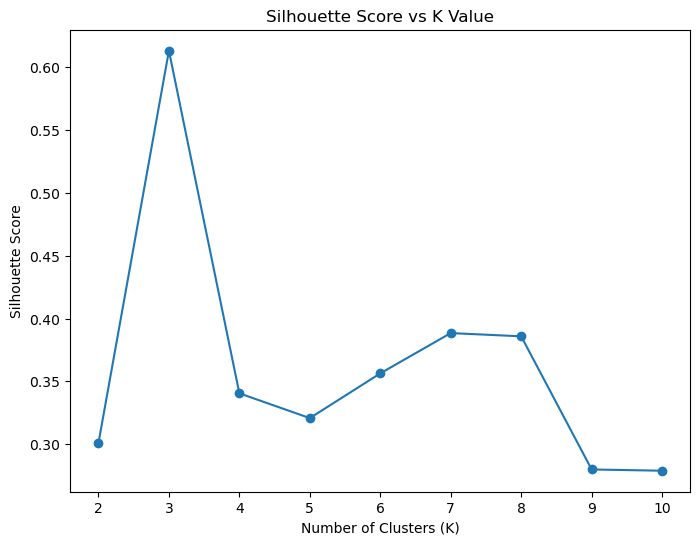

+-------------------------------------------------------------------------------------------------------------------+----------+
|scaled_features                                                                                                    |prediction|
+-------------------------------------------------------------------------------------------------------------------+----------+
|[1.5247929889453213,1.0669707684645506,0.1570388489525926,0.6270881095218181,2.3822024311069536,1.50974850455722]  |0         |
|[0.0,1.0669707684645506,0.1869192029083595,0.6270881095218181,1.6349753770409152,0.25162475075953666]              |0         |
|[0.0,1.0669707684645506,0.1869192029083595,0.6270881095218181,1.1671283103175818,0.25162475075953666]              |0         |
|[0.0,5.334853842322753,0.17625202286547947,0.6270881095218181,2.2795533469425173,0.7252713404245469]               |1         |
|[0.0,1.0669707684645506,0.4933372865646731,4.389616766652727,1.0774489075466143,0.35523494224875

In [31]:
# Select relevant columns for clustering, excluding label data like 'is_fraud'
feature_columns = ["promo_amount", "shipment_fee", "total_amount", "quantity", "item_price", "purchase_count"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Standardize the features (important for K-Means)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Apply assembler and scaler
data_assembled = assembler.transform(transformed_df_cleaned)
data_scaled = scaler.fit(data_assembled).transform(data_assembled)

# Find the optimal K value using the Silhouette score
silhouette_scores = []
k_values = list(range(2, 11))  # Test K values between 2 and 10

for k in k_values:
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(data_scaled)
    
    # Make predictions and evaluate the model
    predictions = model.transform(data_scaled)
    evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette")
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)
    print(f"K = {k}, Silhouette Score = {silhouette_score}")

# Plot the silhouette scores to visualize the best K
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs K Value')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# Train the KMeans model using the best K (based on highest silhouette score)
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
kmeans_optimal = KMeans(featuresCol="scaled_features", k=optimal_k, seed=42)
kmeans_model = kmeans_optimal.fit(data_scaled)

# Make predictions using the optimal KMeans model
final_predictions = kmeans_model.transform(data_scaled)

# Show the cluster assignments
final_predictions.select("scaled_features", "prediction").show(truncate=False)

# Analyze the clusters by calculating averages of important features
cluster_analysis = final_predictions.groupBy("prediction").agg(
    F.avg("promo_amount").alias("avg_promo_amount"),
    F.avg("shipment_fee").alias("avg_shipment_fee"),
    F.avg("total_amount").alias("avg_total_amount"),
    F.avg("quantity").alias("avg_quantity"),
    F.avg("item_price").alias("avg_item_price"),
    F.avg("purchase_count").alias("avg_purchase_count"),
    F.count("prediction").alias("count")
)

# Show the characteristics of each cluster
cluster_analysis.show()

# Optionally, check the fraud distribution in each cluster
fraud_distribution = final_predictions.groupBy("prediction").agg(
    F.sum("is_fraud").alias("fraud_count"),
    F.count("is_fraud").alias("total_count")
)

fraud_distribution = fraud_distribution.withColumn("fraud_ratio", col("fraud_count") / col("total_count"))
fraud_distribution.show()


Based on the K-Means clustering results, we identified three distinct customer groups, with clear differences between fraudulent and legitimate behaviors. The analysis of these clusters shows that fraudsters tend to behave differently from regular customers.

In Cluster 2, which had the highest fraud ratio of 24%, we found that fraudsters generally make higher-value transactions. The average total amount for this group was around 4.86 million, which is much higher compared to the other clusters. Also, fraudsters in this cluster tend to buy more items per order, averaging nearly 4 items. This suggests that fraudsters might target bulk purchases, possibly of items that are easier to resell.

Cluster 1 had a lower fraud ratio of around 5.7%, and the fraudulent behavior here is more moderate. Fraudsters in this group still make higher-value purchases but usually with fewer items per transaction (about 1.4 items on average). It seems like these fraudsters might be testing smaller transactions before attempting larger ones, possibly to check the system's defenses.

Finally, Cluster 0 had the lowest fraud ratio, at just under 4%. This group represents more typical customer behavior, with smaller, more frequent purchases and lower overall activity. Fraudsters in this cluster blend in more easily with regular customers, making them harder to detect.

Overall, fraudsters seem to prefer high-value transactions and tend to purchase in bulk. They might also experiment with smaller transactions to probe the system. Keeping an eye on large orders or unusual purchasing patterns could help in detecting fraud earlier.

### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  
Please see the specification for this task and add markdown cells(word limit: 500).


<h3>Introduction</h3>

The rise of big data has really changed the game for many industries. Organizations can now gather and analyze huge amounts of data, which is pretty amazing. But with this power comes a lot of responsibility regarding how they handle that data, especially when it comes to ethics, privacy, and security.

First off, data ethics is all about the moral principles that guide how data should be collected and used. It emphasizes fairness and respect for people's rights. Then there's data privacy, which focuses on giving individuals control over their personal information and how it’s used. Lastly, we have data security, which is crucial for protecting information from unauthorized access or breaches.

So while big data opens up tons of opportunities for businesses, they really need to be careful and responsible in how they manage it. Balancing these three areas is key to ensuring that data is handled properly in our increasingly data-driven world.

<h3> Significance of Data Ethics in Big Data Processing </h3>

Data ethics plays a crucial role in big data processing because unethical practices can lead to the misuse and exploitation of sensitive information. A good example of this is the General Data Protection Regulation (GDPR), which highlights the importance of ethical data handling. It requires organizations to get user consent before collecting personal data, ensuring transparency and giving users control over their own information.

On the flip side, we’ve seen some serious ethical breaches, like the Facebook-Cambridge Analytica scandal. In that case, millions of users’ data were harvested without their consent, showing just how damaging it can be when ethical standards are ignored.

Finding a balance between technological advancements and ethical responsibility is really important. We need to make sure that the potential of big data is used in a way that protects individuals, maintains fairness, and builds trust. By prioritizing ethics in data handling, organizations can harness big data responsibly and avoid causing harm to people.


<h3> Challenges and Importance of Data Privacy in Big Data</h3>

Ensuring privacy in the world of big data has become increasingly difficult as more personal information is collected, often beyond what is needed. Regulations like the GDPR have been introduced to address these concerns, giving users more control over their data and holding companies accountable with fines for violations. These regulations are essential to ensure organizations respect user privacy.

Beyond legal frameworks, tools like data anonymization and differential privacy also play a key role in protecting user data during analysis. Anonymization removes identifiable details from datasets, while differential privacy introduces small modifications to ensure individual information isn’t revealed during data processing. While these techniques help balance the need for data analysis and privacy, they still need further improvement to be widely effective across all industries.

<h3>Summary </h3>

In conclusion, as the use of big data continues to expand, organizations must confront the growing ethical, privacy, and security issues. Adopting ethical data practices helps build trust with consumers, while privacy regulations like GDPR ensure user rights are respected. On the security front, encryption and access controls are crucial, but with evolving cyber threats, businesses need to adopt stronger and more innovative security protocols. Moving forward, balancing innovation with responsibility will be critical in ensuring data is processed securely, ethically, and in a way that respects individual privacy.

## References:
Please add your references below:

<ol>
<li>
European Parliament. (2016). Regulation (EU) 2016/679 (General Data Protection Regulation). Official Journal of the European Union. 
</li> 
<li>
Richards, N. M., & King, J. H. (2014). Big data ethics. Wake Forest Law Review, 49(2), 393-432.
</li> 
<li>
Zwitter, A. (2014). Big data ethics. Big Data & Society, 1(2), 1-6. 
</li>
<li>
Tene, O., & Polonetsky, J. (2012). Privacy in the age of big data: A time for big decisions. Stanford Law Review Online, 64(2), 63-69.
</li>
<li>
Mayer-Schönberger, V., & Cukier, K. (2013). Big Data: A Revolution That Will Transform How We Live, Work, and Think. Eamon Dolan/Houghton Mifflin Harcourt.
</li> 
<li>
Solove, D. J. (2013). Introduction: Privacy self-management and the consent dilemma. Harvard Law Review, 126(7), 1880-1903.
</li>    
</ol>    